# KPI Revenue

## Libraries

In [1]:
# importing all relevant libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, timedelta
from matplotlib.dates import date2num

## Styles

In [15]:
# set seaborn styles
sns.set()
sns.set_style("whitegrid")
sns.set_palette("rocket")

# set pandas display styles
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 2000)

## Data reading

In [16]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    return trip_data

## KPI generation

### Read in data

In [106]:
#
# TASK: CALCULATE REVENUE PER BIKE FOR BOTH CITIES BREMEN AND DÜSSELDORF
#       CALCULATE KPI HOURLY, VISUALIZE OVER TIME (DAY, WEEK, MONTH)
#

def generate_revenue_per_hour_for_city(data, city, start_date, end_date):
    '''
    Generates plots of revenue per hour, summed, and revenue per hour, on average,
    for a given city and time frame. For each city 4 plots are generated, 2 of those scatter plots
    and 2 line plots, plotting both KPI's, respectively.

    :param city: a city in string format, e.g. "Bremen" or "Duesseldorf"
    :param start_date: an iso format time string, e.g. "2019-03-28 12:00:00"
    :param end_date: an iso format time string, e.g. "2019-03-31 12:00:00"
    '''

    # sorting and key stats of data
    dat = data.sort_values(by=['datetime_start'], axis=0)

    def calc_revenue(x):
        if (x % pd.Timedelta(minutes=30)) > pd.Timedelta(minutes=0):
            return float(math.floor(x / pd.Timedelta(minutes=30) + 1))
        else:
            return float(math.floor(x / pd.Timedelta(minutes=30)))
                              
    # count trip duration intervals for each trip, i.e. how much revenue each trip generated,
    # by setting the revenue to 1 plus the number of 30-minute durations fitting into the trip duration
    dat["revenue_per_trip"] = dat["trip_duration"].apply(lambda x: calc_revenue(x))

    # SET TIME WINDOW FOR HOURLY GROUPING OF VALUES
    startDate = datetime.fromisoformat(start_date)
    endDate = datetime.fromisoformat(end_date)

    # select rows in the given time window
    mask = (dat["datetime_start"] > startDate) & (dat["datetime_start"] <= endDate)
    dat_time_framed = dat.loc[mask]

    # Group data in the given time window by hours and aggregate the revenue per trip:
    # as sum over all rented bikes in a specific hour, and as average over all rented bikes in a specific hour
    times = pd.DatetimeIndex(dat_time_framed.datetime_start)
    groupedByHours = dat_time_framed.groupby([times.month, times.day, times.hour])[
        "revenue_per_trip"].agg(num_of_trips_per_hour="count", revenue_per_hour_sum="sum", revenue_per_hour_avg="mean")
    
    # reset index to get time labels as column labels
    groupedByHours.index.rename(["month", "day", "hour"], inplace=True)
    groupedByHours.reset_index(inplace=True)
    
    # generate date column for plot labelling
    groupedByHours["date"] = "2019-" + groupedByHours["month"].astype(str) + "-" +  groupedByHours["day"].astype(str) + " " + \
                             groupedByHours["hour"].astype(str) + ":00:00"

    # generate datetime column for checking of weekdays
    groupedByHours["datetime"] = [pd.to_datetime(d) for d in groupedByHours.date]

    # check, if date is weekday (.weekday() returns 0 for a monday, and 6 for a sunday)
    groupedByHours["is_weekday"] = [dt.weekday() <= 4 for dt in groupedByHours.datetime]
    
    return groupedByHours


In [107]:
dataBr = read_data("Bremen")
dataDu = read_data("Duesseldorf")

In [117]:
bremen = generate_revenue_per_hour_for_city(dataBr, "Bremen", "2019-02-01 00:00:00", "2019-02-02 23:59:00")
bremen_gr_hourly = bremen.groupby("hour")["revenue_per_hour_sum"].agg(average_hourly_total_revenue="mean")
bremen_gr_hourly["average_hourly_mean_revenue"] = bremen.groupby("hour")["revenue_per_hour_avg"].agg("mean")                                                                       
print(bremen_gr_hourly.head(50))

duesseldorf = generate_revenue_per_hour_for_city(dataDu, "Duesseldorf", "2019-02-01 00:00:00", "2019-02-02 23:59:00")
duesseldorf_gr_hourly = duesseldorf.groupby("hour")["revenue_per_hour_sum"].agg(average_hourly_total_revenue="mean", average_hourly_mean_revenue="mean")

      average_hourly_total_revenue  average_hourly_mean_revenue
hour                                                           
0                              4.0                     1.166667
1                              1.5                     1.000000
2                              1.0                     1.000000
3                              1.0                     1.000000
4                              1.0                     1.000000
5                              4.0                     1.000000
6                              7.5                     1.041667
7                             17.5                     1.386957
8                              5.5                     1.000000
9                              2.5                     1.000000
10                            11.0                     1.090909
11                            13.5                     1.291667
12                            22.0                     1.380392
13                            14.5      

## Plotting

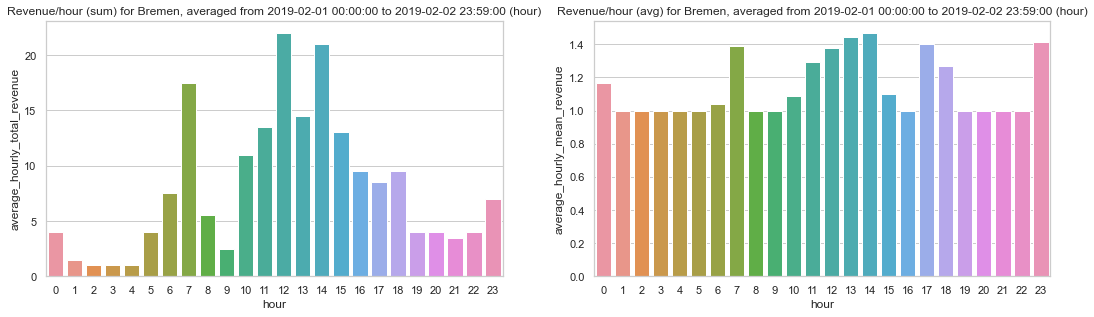

In [125]:
# create figure and axes
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# generate scatter plots
plot1 = sns.barplot(ax=ax1, data=bremen_gr_hourly.reset_index(), x="hour", y="average_hourly_total_revenue", ci=None)
plot2 = sns.barplot(ax=ax2, data=bremen_gr_hourly.reset_index(), x="hour", y="average_hourly_mean_revenue", ci=None)

city = "Bremen"
startDate = "2019-02-01 00:00:00"
endDate = "2019-02-02 23:59:00"
time_interval = "hour"

ax1.set_title(f"Revenue/hour (sum) for {city}, averaged from {startDate} to {endDate} ({time_interval})")
ax2.set_title(f"Revenue/hour (avg) for {city}, averaged from {startDate} to {endDate} ({time_interval})")

fig1.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25)

In [126]:
plt.show()